In [72]:
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, \
    statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
pd.set_option('display.max_columns', None)

In [2]:
# path = os.getcwd()
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
census_starter = pd.read_csv('../data/census_starter.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

## Analyze train data to improve

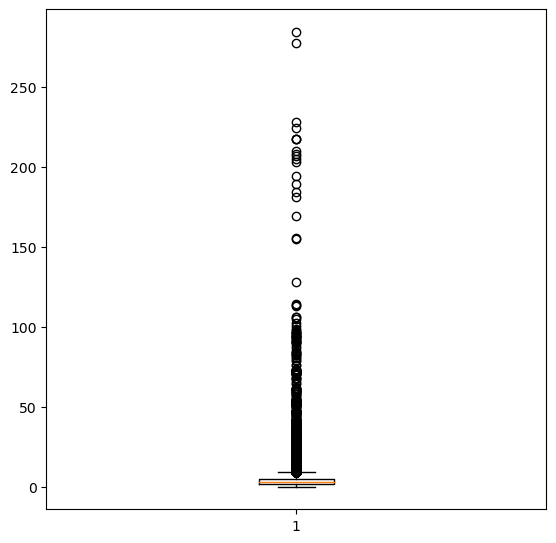

In [3]:
fig = plt.figure(figsize =(5, 5))
 
# # Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(train.microbusiness_density)

plt.show(fig)

# Right Skewed Data

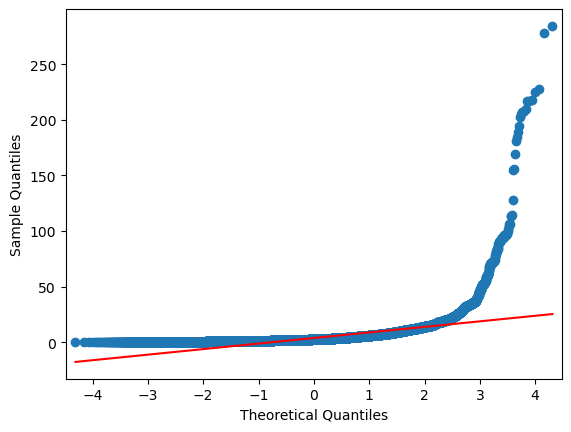

In [4]:
sm.qqplot(train.microbusiness_density, line ='s')
plt.show()

In [5]:
Q3, Q1 = np.percentile(train.microbusiness_density, [75 ,25])
IQR = Q3 - Q1
lower_range = Q1 - (1.5 * IQR)
upper_range = Q3 + (1.5 * IQR)
p95, p5 = np.percentile(train.microbusiness_density, [95, 5])
upper_95 = train[train.microbusiness_density > p95]
lower_5 = train[train.microbusiness_density < p5]
print(f"Lower Fence: {lower_range}\nUpper Fence: {upper_range}\nUpper 95: {p95}\nlower 5: {p5}")

Lower Fence: -2.6804857
Upper Fence: 8.839060700000001
Upper 95: 10.553019999999998
lower 5: 0.81756973


* Negative Lower fence with all postive values

-2.6804857
* Looking to cap/floor the values

In [6]:
skew = train.microbusiness_density.skew()
print(skew)

15.970180887733518


In [7]:
upper_95.sort_values('microbusiness_density').groupby(['state','county'])['microbusiness_density'].mean()

state       county             
Alaska      Bristol Bay Borough    13.661058
            Denali Borough         14.241852
Arizona     Maricopa County        14.339256
Arkansas    Greene County          13.715641
California  Alameda County         10.864506
                                     ...    
Wisconsin   Langlade County        17.690652
Wyoming     Johnson County         21.465157
            Laramie County         13.380343
            Sheridan County        73.510410
            Teton County           26.337935
Name: microbusiness_density, Length: 206, dtype: float64

* Issaquena County Mississippi poorest Country in the United States many zeros
* Teton County Wyoming Rich Place to live High Outlier


In [8]:
train[train.microbusiness_density == 0].groupby(['state','county'])['microbusiness_density'].count()

state        county          
Mississippi  Issaquena County    21
Texas        Loving County        5
Name: microbusiness_density, dtype: int64

In [9]:
train[(train.microbusiness_density > upper_range)].groupby(['state','county'])['microbusiness_density'].count()

state     county             
Alaska    Bristol Bay Borough    39
          Denali Borough         39
Arizona   Maricopa County        39
          Yavapai County         39
Arkansas  Greene County           6
                                 ..
Wyoming   Converse County         8
          Johnson County         39
          Laramie County         39
          Sheridan County        39
          Teton County           39
Name: microbusiness_density, Length: 286, dtype: int64

Create mean outliers for the IQR, upper 95%, and lower 5%

## Quantile-based Flooring and Capping?

In [10]:
mean_outliers_fence = pd.DataFrame(train[(train.microbusiness_density > upper_range) | (train.microbusiness_density < lower_range)].groupby(['state','county'])['microbusiness_density'].transform('mean'),
                             columns = ['microbusiness_density'])
mean_outliers_fence

,microbusiness_density
2769,13.398596
2770,13.398596
2771,13.398596
2772,13.398596
2773,13.398596
...,...
122143,26.337935
122144,26.337935
122145,26.337935
122146,26.337935


Replacing The 1.5*IQR upper bound with mean state_county improved the skew by 5 ( 15 -> 10)

In [11]:
train2 = train.copy()
fence = (train.microbusiness_density > upper_range) | (train.microbusiness_density < lower_range)
train2.loc[fence, 'microbusiness_density'] = mean_outliers_fence.microbusiness_density
train2.microbusiness_density.skew()

10.140847200280694

In [12]:
mean_outliers_cap = pd.DataFrame(train[train.microbusiness_density > p95].groupby(['state','county'])['microbusiness_density'].transform('mean'),
                             columns = ['microbusiness_density'])
mean_outliers_cap

,microbusiness_density
2769,13.661058
2770,13.661058
2771,13.661058
2772,13.661058
2773,13.661058
...,...
122143,26.337935
122144,26.337935
122145,26.337935
122146,26.337935


In [13]:
train3 = train.copy()
cap = train.microbusiness_density > p95
train3.loc[cap, 'microbusiness_density'] = mean_outliers_cap.microbusiness_density
train3.microbusiness_density.skew()

10.131920886645172

In [52]:
mean_outliers_floor = pd.DataFrame(train[train.microbusiness_density < p5].groupby(['state','county'])['microbusiness_density'].transform('mean'),
                             columns = ['microbusiness_density'])
mean_outliers_floor

,microbusiness_density
213,0.794335
220,0.794335
221,0.794335
222,0.794335
234,0.754635
...,...
120115,0.557493
120116,0.557493
120117,0.557493
120118,0.557493


In [53]:
train4 = train.copy()
floor = train.microbusiness_density < p5
train4.loc[floor, 'microbusiness_density'] = mean_outliers_floor.microbusiness_density
train4.microbusiness_density.skew()

15.970399463060172

In [54]:
mean_outliers_floorcap = pd.DataFrame(train[(train.microbusiness_density < p5)|(train.microbusiness_density > p95)].groupby(['state','county'])['microbusiness_density'].transform('mean'),
                             columns = ['microbusiness_density'])
mean_outliers_floorcap

,microbusiness_density
213,0.794335
220,0.794335
221,0.794335
222,0.794335
234,0.754635
...,...
122143,26.337935
122144,26.337935
122145,26.337935
122146,26.337935


In [55]:
train5 = train.copy()
floorcap = (train.microbusiness_density < p5)|(train.microbusiness_density > p95)
train5.loc[floorcap, 'microbusiness_density'] = mean_outliers_floorcap.microbusiness_density
train5.microbusiness_density.skew()

10.132095443597212

    y is microbusiness_density prediction for row_id

    text X : row_id	cfips	first_day_of_month

train original

In [80]:
def train_test(train, test, model):
    X = pd.DataFrame(train, columns = ['row_id','cfips', 'first_day_of_month'])
    y = train.microbusiness_density

    X.row_id = X.row_id.str.replace("_", '').str.replace("-", '')
    X.first_day_of_month = X.first_day_of_month.str.replace("-", '')
    X = X.astype('int64')
    m = model(X, y)

    test_x = test.copy()
    test_x.row_id = test_x.row_id.str.replace("_", '').str.replace("-", '')
    test_x.first_day_of_month = test_x.first_day_of_month.str.replace("-", '')
    test_x = test_x.astype('int64')

    y_pred = pd.Series(m.predict(test_x))
    y_pred = y_pred.set_axis(test['row_id'])
    
    return m, y_pred

testing 
* train : original
* train2: 1.5 * IQR replaced with city-country grouped mean
* train3: 95% cap replaced with city-country grouped mean
* train4: 5% floor replaced with city-country grouped mean
* train5: cap and floor replaced with city-country grouped mean

In [82]:
lm, y_pred = train_test(train, test, LinearRegression().fit)
lm2, y_pred2 = train_test(train2, test, LinearRegression().fit)
lm3, y_pred3 = train_test(train3, test, LinearRegression().fit)
lm4, y_pred4 = train_test(train4, test, LinearRegression().fit)
lm5, y_pred5 = train_test(train5, test, LinearRegression().fit)
# pm, y_pred6 = train_test(train2, test, PolynomialFeatures(degree = 2).fit_transform)

    Results from 5 predictions submission
* train2 IQR had the highest score

In [64]:
submission = y_pred2.reset_index('row_id').rename(columns={0:"microbusiness_density"}).reset_index(drop=True)
submission.to_csv('..\data\submission.csv', index=False)
submission

,row_id,microbusiness_density
0,1001_2022-11-01,3.965934
1,1003_2022-11-01,3.965926
2,1005_2022-11-01,3.965918
3,1007_2022-11-01,3.965910
4,1009_2022-11-01,3.965903
...,...,...
25075,56037_2023-06-01,3.776640
25076,56039_2023-06-01,3.776632
25077,56041_2023-06-01,3.776625
25078,56043_2023-06-01,3.776617
